In [ ]:
from pypots.data import load_specific_dataset
import tsdb
import numpy as np
from sklearn.preprocessing import StandardScaler
from pygrinder import mcar, mnar_t
from pypots.data import load_specific_dataset
from pypots.imputation import SAITS
from pypots.imputation import CSDI
from pypots.utils.metrics import calc_mae
from pypots.utils.metrics import calc_rmse
from pypots.utils.metrics import calc_mre
from pypots.utils.metrics import calc_quantile_crps
from scipy import stats

def calc_nlpd(y_pred, y_true, mask, y_pred_std):
    metric = (((y_true - y_pred)**2) * mask) / ((2 * y_pred_std**2) + 1e-12) + (np.log(y_pred_std + 1e-12) * mask) + 0.5 * np.log(2 * np.pi)

    return metric.sum() / (mask.sum() + 1e-12)

def calc_picp(y_pred, y_true, mask, y_pred_std, alpha=0.90):
    p_left, p_right = stats.norm.interval(confidence=alpha, loc=y_pred, scale=y_pred_std)
    metric = (y_true > p_left) * (y_true <= p_right)

    return (metric * mask).sum() / (mask.sum() + 1e-12)

In [ ]:
data_electricity = tsdb.load("electricity_transformer_temperature")
data = data_electricity['ETTh1'].iloc[:-20]

X_ori = data.to_numpy().reshape(-1, 24, 7)
X = np.copy(X_ori)
X_ori = X_ori[:72, :, :]
X = X[72:, :, :]
X_ori_missed = mcar(X_ori, 0.1)
dataset = {"X" : X}
n_steps=X.shape[1]
n_features=X.shape[2]
print(X.shape)

2024-05-06 13:14:35 [INFO]: You're using dataset electricity_transformer_temperature, please cite it properly in your work. You can find its reference information at the below link: 
https://github.com/WenjieDu/TSDB/tree/main/dataset_profiles/electricity_transformer_temperature
2024-05-06 13:14:35 [INFO]: Dataset electricity_transformer_temperature has already been downloaded. Processing directly...
2024-05-06 13:14:35 [INFO]: Dataset electricity_transformer_temperature has already been cached. Loading from cache directly...
2024-05-06 13:14:35 [INFO]: Loaded successfully!


(725, 24, 7)


In [ ]:
data

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...
2018-06-25 19:00:00,9.511,2.813,6.183,1.315,3.320,1.097,10.552000
2018-06-25 20:00:00,12.994,3.483,8.457,1.635,4.447,1.249,9.989000
2018-06-25 21:00:00,12.458,3.751,8.564,2.132,4.082,1.066,9.989000


In [ ]:
csdi = CSDI(n_features=n_features, n_layers=4, n_heads=8, n_channels=64, d_time_embedding=128, d_feature_embedding=128, d_diffusion_embedding=128, epochs=150, saving_path='csdi_model')

csdi.fit(dataset)

2024-05-06 13:14:35 [INFO]: No given device, using default device: cuda
2024-05-06 13:14:35 [INFO]: Model files will be saved to csdi_model/20240506_T131435
2024-05-06 13:14:35 [INFO]: Tensorboard file will be saved to csdi_model/20240506_T131435/tensorboard
/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-05-06 13:14:37 [INFO]: CSDI initialized with the given hyperparameters, the number of trainable parameters: 471,745
2024-05-06 13:14:57 [INFO]: Epoch 001 - training loss: 0.7432
2024-05-06 13:15:00 [INFO]: Epoch 002 - training loss: 0.5142
2024-05-06 13:15:03 [INFO]: Epoch 003 - training loss: 0.5012
2024-05-06 13:15:06 [INF

In [ ]:
csdi.optimizer.torch_optimizer.param_groups[0]['lr'] = 0.0001
csdi.epochs = 30
csdi.fit(dataset)

2024-05-06 13:26:04 [INFO]: Epoch 001 - training loss: 0.3096
2024-05-06 13:26:09 [INFO]: Epoch 002 - training loss: 0.3117
2024-05-06 13:26:13 [INFO]: Epoch 003 - training loss: 0.2712
2024-05-06 13:26:18 [INFO]: Epoch 004 - training loss: 0.2765
2024-05-06 13:26:22 [INFO]: Epoch 005 - training loss: 0.2779
2024-05-06 13:26:27 [INFO]: Epoch 006 - training loss: 0.2660
2024-05-06 13:26:32 [INFO]: Epoch 007 - training loss: 0.2941
2024-05-06 13:26:36 [INFO]: Epoch 008 - training loss: 0.2927
2024-05-06 13:26:41 [INFO]: Epoch 009 - training loss: 0.2796
2024-05-06 13:26:45 [INFO]: Epoch 010 - training loss: 0.2778
2024-05-06 13:26:50 [INFO]: Epoch 011 - training loss: 0.2701
2024-05-06 13:26:55 [INFO]: Epoch 012 - training loss: 0.2723
2024-05-06 13:27:00 [INFO]: Epoch 013 - training loss: 0.3109
2024-05-06 13:27:04 [INFO]: Epoch 014 - training loss: 0.2753
2024-05-06 13:27:09 [INFO]: Epoch 015 - training loss: 0.2711
2024-05-06 13:27:14 [INFO]: Epoch 016 - training loss: 0.2989
2024-05-

In [ ]:
csdi.optimizer.torch_optimizer.param_groups[0]['lr'] = 0.00001
csdi.epochs = 20
csdi.fit(dataset)

2024-05-06 13:28:22 [INFO]: Epoch 001 - training loss: 0.2762
2024-05-06 13:28:26 [INFO]: Epoch 002 - training loss: 0.2576
2024-05-06 13:28:31 [INFO]: Epoch 003 - training loss: 0.2726
2024-05-06 13:28:35 [INFO]: Epoch 004 - training loss: 0.2766
2024-05-06 13:28:40 [INFO]: Epoch 005 - training loss: 0.2996
2024-05-06 13:28:44 [INFO]: Epoch 006 - training loss: 0.2429
2024-05-06 13:28:49 [INFO]: Epoch 007 - training loss: 0.3118
2024-05-06 13:28:54 [INFO]: Epoch 008 - training loss: 0.2609
2024-05-06 13:28:58 [INFO]: Epoch 009 - training loss: 0.2894
2024-05-06 13:29:03 [INFO]: Epoch 010 - training loss: 0.3028
2024-05-06 13:29:08 [INFO]: Epoch 011 - training loss: 0.2672
2024-05-06 13:29:12 [INFO]: Epoch 012 - training loss: 0.2884
2024-05-06 13:29:17 [INFO]: Epoch 013 - training loss: 0.2752
2024-05-06 13:29:21 [INFO]: Epoch 014 - training loss: 0.2895
2024-05-06 13:29:26 [INFO]: Epoch 015 - training loss: 0.2773
2024-05-06 13:29:30 [INFO]: Epoch 016 - training loss: 0.2727
2024-05-

In [ ]:
n_preds = 30
imputation_csdi = csdi.predict(dataset, n_sampling_times=n_preds)  # impute the originally-missing values and artificially-missing values
indicating_mask = np.isnan(X_ori_missed) ^ np.isnan(X_ori)  # indicating mask for imputation error calculation

In [ ]:
mae_csdi = calc_mae(np.median(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
rmse_csdi = calc_rmse(np.median(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
mape_csdi = calc_mre(np.median(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
crps_csdi = calc_quantile_crps(imputation_csdi['imputation'], np.nan_to_num(X_ori), indicating_mask)
nlpd_csdi = calc_nlpd(np.mean(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask, np.std(imputation_csdi['imputation'], axis=1))
picp_csdi = calc_picp(np.mean(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask, np.std(imputation_csdi['imputation'], axis=1))

/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [ ]:
print(mae_csdi, rmse_csdi, mape_csdi, crps_csdi, nlpd_csdi, picp_csdi)

0.30193179175640933 0.6013545006005442 0.054943833671725235 0.10558411949559261 8.498994802102162 0.8830318408774657


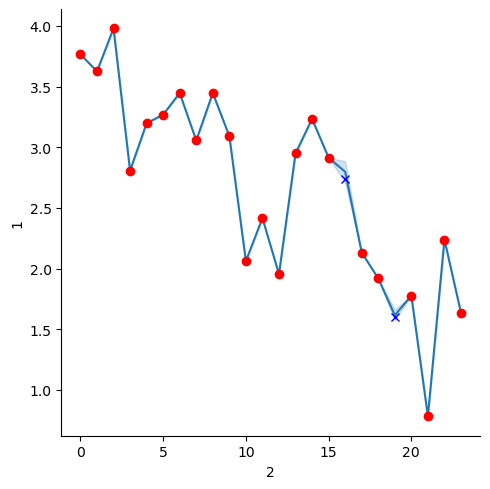

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

day = 132
station = 3

d = pd.DataFrame(columns=['1', '2'])
for i in range(n_preds):
    for j in range(n_steps):
        d = pd.concat([d, pd.DataFrame([{'1': imputation_csdi['imputation'][day, i, j, station], '2' : j}])], ignore_index=True)
sns.relplot(data=d, y = '1', x='2', kind='line')
for i, marker in enumerate(indicating_mask[day, :, station]):
    plt.plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

In [ ]:
saits = SAITS(n_steps=n_steps, n_features=n_features, n_layers=2, d_model=256, d_inner=128, n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=200, saving_path='saits')
saits.fit(dataset)

2024-05-06 13:47:31 [INFO]: No given device, using default device: cuda
2024-05-06 13:47:31 [INFO]: Model files will be saved to saits/20240506_T134731
2024-05-06 13:47:31 [INFO]: Tensorboard file will be saved to saits/20240506_T134731/tensorboard
2024-05-06 13:47:31 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,327,910
2024-05-06 13:47:37 [INFO]: Epoch 001 - training loss: 7.3903
2024-05-06 13:47:43 [INFO]: Epoch 002 - training loss: 5.2114
2024-05-06 13:47:48 [INFO]: Epoch 003 - training loss: 4.1908
2024-05-06 13:47:53 [INFO]: Epoch 004 - training loss: 3.4493
2024-05-06 13:47:58 [INFO]: Epoch 005 - training loss: 2.8479
2024-05-06 13:48:03 [INFO]: Epoch 006 - training loss: 2.4262
2024-05-06 13:48:07 [INFO]: Epoch 007 - training loss: 2.2167
2024-05-06 13:48:12 [INFO]: Epoch 008 - training loss: 2.0429
2024-05-06 13:48:16 [INFO]: Epoch 009 - training loss: 1.9545
2024-05-06 13:48:21 [INFO]: Epoch 010 - training loss: 1.8752
2024-05

In [ ]:
imputation_saits = saits.predict(dataset)  # impute the originally-missing values and artificially-missing values
mae_saits = calc_mae(imputation_saits['imputation'], np.nan_to_num(X_ori), indicating_mask)
rmse_saits = calc_rmse(imputation_saits['imputation'], np.nan_to_num(X_ori), indicating_mask)
mape_saits = calc_mre(imputation_saits['imputation'], np.nan_to_num(X_ori), indicating_mask)
crps_saits = calc_quantile_crps(np.expand_dims(imputation_saits['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)

In [ ]:
print(mae_saits, rmse_saits, mape_saits, crps_saits)

0.3057318404198171 0.5621585704104365 0.05563534495807292 0.055635351883737666


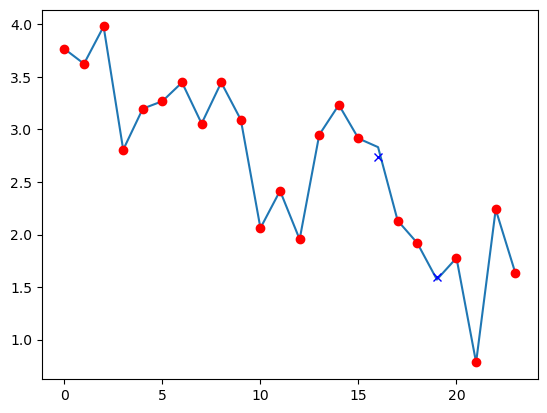

In [ ]:
plt.plot(imputation_saits['imputation'][day][:, station])
for i, marker in enumerate(indicating_mask[day, :, station]):
    plt.plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

In [ ]:
from pypots.imputation import BRITS

brits = BRITS(n_steps=n_steps, n_features=n_features, rnn_hidden_size=128, epochs=100, saving_path='brits')
brits.fit(dataset)

2024-05-06 13:59:49 [INFO]: No given device, using default device: cuda
2024-05-06 13:59:50 [INFO]: Model files will be saved to brits/20240506_T135949
2024-05-06 13:59:50 [INFO]: Tensorboard file will be saved to brits/20240506_T135949/tensorboard
2024-05-06 13:59:50 [INFO]: BRITS initialized with the given hyperparameters, the number of trainable parameters: 151,744
2024-05-06 14:00:33 [INFO]: Epoch 001 - training loss: 11.5054
2024-05-06 14:01:17 [INFO]: Epoch 002 - training loss: 9.5717
2024-05-06 14:01:58 [INFO]: Epoch 003 - training loss: 8.1904
2024-05-06 14:02:39 [INFO]: Epoch 004 - training loss: 7.2318
2024-05-06 14:03:22 [INFO]: Epoch 005 - training loss: 6.5503
2024-05-06 14:04:00 [INFO]: Epoch 006 - training loss: 5.9771
2024-05-06 14:04:41 [INFO]: Epoch 007 - training loss: 5.5008
2024-05-06 14:05:22 [INFO]: Epoch 008 - training loss: 5.0886
2024-05-06 14:06:05 [INFO]: Epoch 009 - training loss: 4.7621
2024-05-06 14:06:45 [INFO]: Epoch 010 - training loss: 4.4875
2024-05-

In [ ]:
imputation_brits = brits.predict(dataset)  # impute the originally-missing values and artificially-missing values
mae_brits = calc_mae(imputation_brits['imputation'], np.nan_to_num(X_ori), indicating_mask)
rmse_brits = calc_rmse(imputation_brits['imputation'], np.nan_to_num(X_ori), indicating_mask)
mape_brits = calc_mre(imputation_brits['imputation'], np.nan_to_num(X_ori), indicating_mask)
crps_brits = calc_quantile_crps(np.expand_dims(imputation_brits['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)

In [ ]:
print(mae_brits, rmse_brits, mape_brits, crps_brits)

0.4020408600298301 1.001638710915991 0.07316111368801373 0.0731611126347592


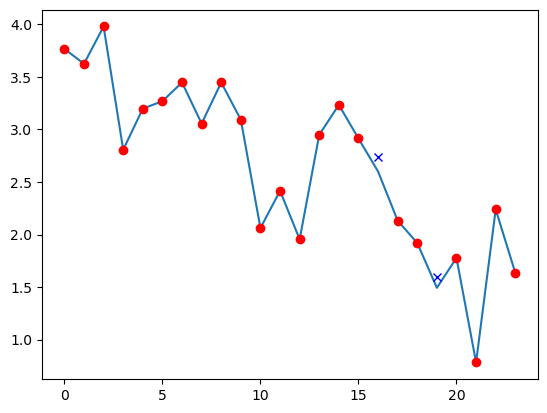

In [ ]:
plt.plot(imputation_brits['imputation'][day][:, station])
for i, marker in enumerate(indicating_mask[day, :, station]):
    plt.plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

In [ ]:
from pypots.imputation import GPVAE

gp_vae = GPVAE(n_steps=n_steps, n_features=n_features, latent_size=256, epochs=200, encoder_sizes=(256, 256), decoder_sizes=(256, 256), saving_path='gp_vae')
gp_vae.fit(dataset)

2024-05-06 15:17:54 [INFO]: No given device, using default device: cuda
2024-05-06 15:17:54 [INFO]: Model files will be saved to gp_vae/20240506_T151754
2024-05-06 15:17:54 [INFO]: Tensorboard file will be saved to gp_vae/20240506_T151754/tensorboard
2024-05-06 15:17:54 [INFO]: GPVAE initialized with the given hyperparameters, the number of trainable parameters: 402,183
2024-05-06 15:17:59 [INFO]: Epoch 001 - training loss: 116775.2816
2024-05-06 15:18:03 [INFO]: Epoch 002 - training loss: 76134.5883
2024-05-06 15:18:08 [INFO]: Epoch 003 - training loss: 74986.0149
2024-05-06 15:18:12 [INFO]: Epoch 004 - training loss: 74708.2989
2024-05-06 15:18:16 [INFO]: Epoch 005 - training loss: 74601.4290
2024-05-06 15:18:20 [INFO]: Epoch 006 - training loss: 74531.7670
2024-05-06 15:18:24 [INFO]: Epoch 007 - training loss: 74415.7680
2024-05-06 15:18:28 [INFO]: Epoch 008 - training loss: 74595.3030
2024-05-06 15:18:33 [INFO]: Epoch 009 - training loss: 74400.3923
2024-05-06 15:18:37 [INFO]: Epoc

In [ ]:
imputation_gp_vae = gp_vae.predict(dataset, n_sampling_times=n_preds)  # impute the originally-missing values and artificially-missing values
mae_gp_vae = calc_mae(np.median(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
rmse_gp_vae = calc_rmse(np.median(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
mape_gp_vae = calc_mre(np.median(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
crps_gp_vae = calc_quantile_crps(imputation_gp_vae['imputation'], np.nan_to_num(X_ori), indicating_mask)
nlpd_gp_vae = calc_nlpd(np.mean(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask, np.std(imputation_gp_vae['imputation'], axis=1))
picp_gp_vae = calc_picp(np.mean(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask, np.std(imputation_gp_vae['imputation'], axis=1))

/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [ ]:
print(mae_gp_vae, rmse_gp_vae, mape_gp_vae, crps_gp_vae, nlpd_gp_vae, picp_gp_vae)

1.0386826345340128 1.5157401820128997 0.1890135701761016 0.18901355643021434 1141362232742.5134 0.0


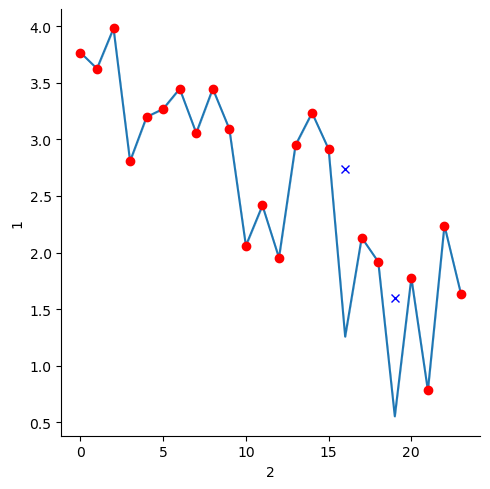

In [ ]:
d = pd.DataFrame(columns=['1', '2'])
for i in range(n_preds):
    for j in range(n_steps):
        d = pd.concat([d, pd.DataFrame([{'1': imputation_gp_vae['imputation'][day, i, j, station], '2' : j}])], ignore_index=True)
sns.relplot(data=d, y = '1', x='2', kind='line')
for i, marker in enumerate(indicating_mask[day, :, station]):
    plt.plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

In [ ]:
np.save('imputation_csdi_ett_2', imputation_csdi['imputation'])
np.save('imputation_saits_ett_2', imputation_saits['imputation'])
np.save('imputation_brits_ett_2', imputation_brits['imputation'])
np.save('imputation_gp_vae_ett_2', imputation_gp_vae['imputation'])

In [ ]:
pd.DataFrame([[mae_csdi, rmse_csdi, mape_csdi, crps_csdi, nlpd_csdi, picp_csdi],
             [mae_saits, rmse_saits, mape_saits, crps_saits, -1, -1],
             [mae_brits, rmse_brits, mape_brits, crps_brits, -1, -1],
             [mae_gp_vae, rmse_gp_vae, mape_gp_vae, crps_gp_vae, nlpd_gp_vae, picp_gp_vae]], index=['CSDI', 'SAITS', 'BRITS', 'GP VAE'], columns=['MAE', 'RMSE', 'MAPE', 'CRPS', 'NLPD', 'PICP'])

,MAE,RMSE,MAPE,CRPS,NLPD,PICP
CSDI,0.301932,0.601355,0.054944,0.105584,8.498995e+00,0.883032
SAITS,0.305732,0.562159,0.055635,0.055635,-1.000000e+00,-1.000000
BRITS,0.402041,1.001639,0.073161,0.073161,-1.000000e+00,-1.000000
GP VAE,1.038683,1.515740,0.189014,0.189014,1.141362e+12,0.000000


In [ ]:
days = np.random.randint(72, size=10)
stations = np.random.randint(7, size=10)

<Figure size 2000x2000 with 0 Axes>

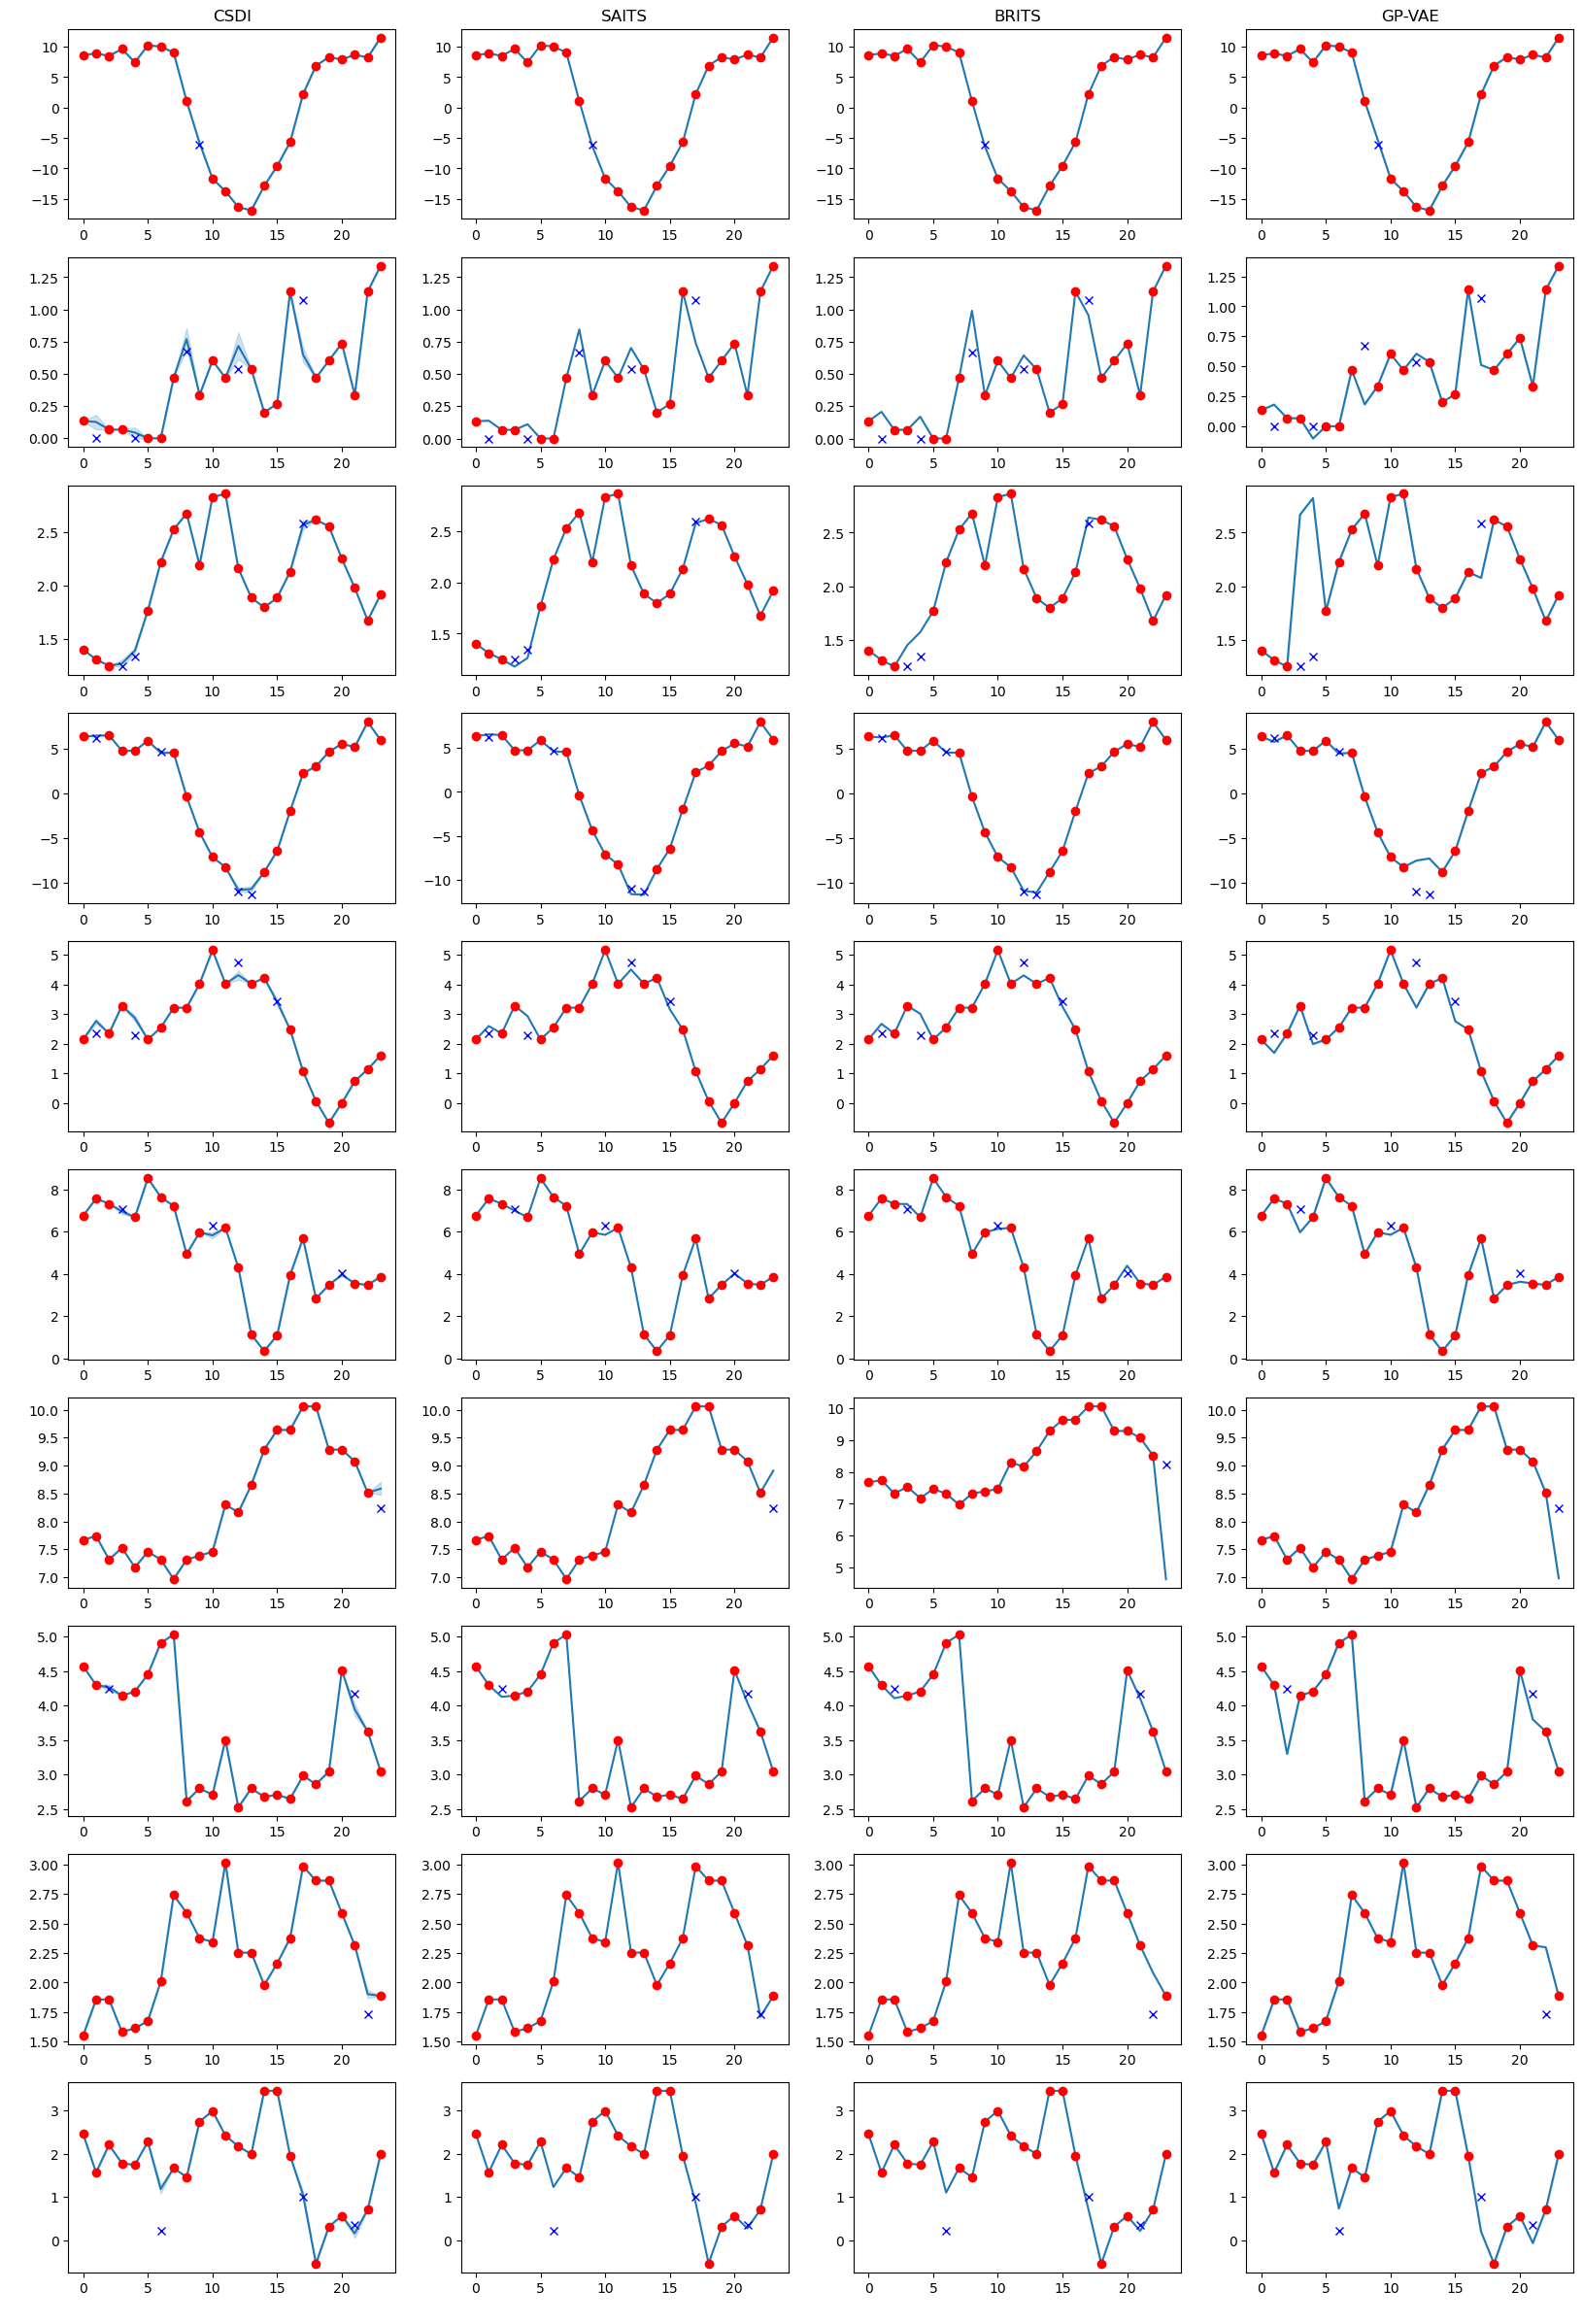

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 20))
fig, ax = plt.subplots(10, 4)
fig.set_figheight(30)
fig.set_figwidth(20)

for ids, day_station in enumerate(zip(days, stations)):
    day = day_station[0]
    station = day_station[1]
    n_preds = 30

    ax[0][0].set_title('CSDI')
    ax[0][1].set_title('SAITS')
    ax[0][2].set_title('BRITS')
    ax[0][3].set_title('GP-VAE')
    ax[ids][0].set_xlabel(' ')
    ax[ids][1].set_xlabel(' ')
    ax[ids][2].set_xlabel(' ')
    ax[ids][3].set_xlabel(' ')
    ax[ids][0].set_ylabel(' ')
    ax[ids][1].set_ylabel(' ')
    ax[ids][2].set_ylabel(' ')
    ax[ids][3].set_ylabel(' ')

    d = pd.DataFrame(columns=['1', '2'])
    for i in range(n_preds):
        for j in range(n_steps):
            d = pd.concat([d, pd.DataFrame([{'1': imputation_csdi['imputation'][day, i, j, station], '2' : j}])], ignore_index=True)
    sns.lineplot(data=d, y = '1', x='2', ax=ax[ids, 0])
    for i, marker in enumerate(indicating_mask[day, :, station]):
        ax[ids, 0].plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

    ax[ids, 1].plot(imputation_saits['imputation'][day][:, station])
    for i, marker in enumerate(indicating_mask[day, :, station]):
        ax[ids, 1].plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

    ax[ids, 2].plot(imputation_brits['imputation'][day][:, station])
    for i, marker in enumerate(indicating_mask[day, :, station]):
        ax[ids, 2].plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

    d = pd.DataFrame(columns=['1', '2'])
    for i in range(n_preds):
        for j in range(n_steps):
            d = pd.concat([d, pd.DataFrame([{'1': imputation_gp_vae['imputation'][day, i, j, station], '2' : j}])], ignore_index=True)
    sns.lineplot(data=d, y = '1', x='2', ax=ax[ids, 3])
    for i, marker in enumerate(indicating_mask[day, :, station]):
        ax[ids, 3].plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')